<a href="https://colab.research.google.com/github/alsombra/Mask_RCNN-colab/blob/master/Mask_RCNN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask-RCNN practice

author: Antônio Luís Sombra

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

# Install libraries

In [3]:
!pip install imgaug
!pip install Cython
!pip install pycocotools
!pip install kaggle

# Clone Repo

In [0]:
!mkdir /mydrive/mask_rcnn

In [5]:
cd /mydrive/mask_rcnn

/content/gdrive/My Drive/mask_rcnn


In [0]:
!git clone https://github.com/alsombra/Mask_RCNN

In [8]:
cd /mydrive/mask_rcnn/Mask_RCNN/

/content/gdrive/My Drive/mask_rcnn/Mask_RCNN


Installing Mask-RCNN lib

In [9]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/process_video.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize_cv.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/.DS_Store -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/m

In [0]:
import os #just another way to navegate through folders - using python
os.chdir('/mydrive/mask_rcnn/Mask_RCNN/samples')

# Prepare Model

In [21]:
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
import importlib
importlib.reload(modellib)
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

... done downloading pretrained model!


# Create Inference Object

In [12]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    RPN_NMS_THRESHOLD = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
 # Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [15]:
cd /mydrive/mask_rcnn/

/content/gdrive/My Drive/mask_rcnn


In [16]:
!wget https://www.dropbox.com/s/j9b8ds6721ept0u/street_tutorial.jpeg

--2020-05-28 13:32:28--  https://www.dropbox.com/s/j9b8ds6721ept0u/street_tutorial.jpeg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/j9b8ds6721ept0u/street_tutorial.jpeg [following]
--2020-05-28 13:32:28--  https://www.dropbox.com/s/raw/j9b8ds6721ept0u/street_tutorial.jpeg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c2293b18b4386bcb26e140f0a.dl.dropboxusercontent.com/cd/0/inline/A4nrv1tm29qxxaFqcVtXhiQQds7qEFepxdd5dYt31V9Oh9Jy9dHmHCWq4K4epZ6vp54goBt1y28g3jKzxP2L0nDVirhONrsvIB1nWp6KXg2rppsqzonssPYXlFgObDjf_9A/file# [following]
--2020-05-28 13:32:29--  https://uc7c2293b18b4386bcb26e140f0a.dl.dropboxusercontent.com/cd/0/inline/A4nrv1tm29qxxaFqcVtXhiQQds7qEFepxdd5dYt31V9Oh9Jy9dHmHCWq4K4epZ6vp54goBt1y28g3jKzxP2L0nDVir

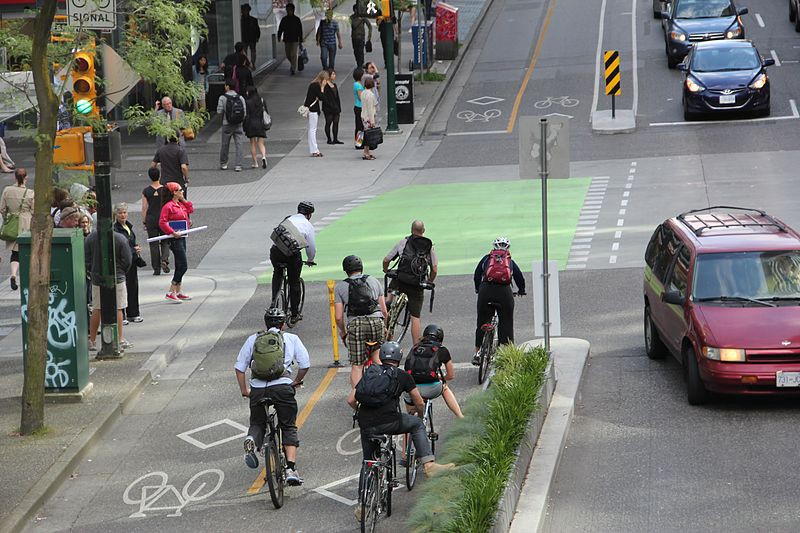

In [31]:
tutorial_image = cv2.imread('street_tutorial.jpeg')
cv2_imshow(tutorial_image)

In [39]:
!wget https://www.dropbox.com/s/y9m063jvfyavpmz/bill.jpg

--2020-05-28 13:43:21--  https://www.dropbox.com/s/y9m063jvfyavpmz/bill.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/y9m063jvfyavpmz/bill.jpg [following]
--2020-05-28 13:43:21--  https://www.dropbox.com/s/raw/y9m063jvfyavpmz/bill.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc1f429e5685a56c841600bface.dl.dropboxusercontent.com/cd/0/inline/A4nLWk7lEhBYkj0PDc2Sjpe5nBb97j0_wlGzeQhVXY7Ju5OpMRRwSyrkbp976KW9VQ9lxmyiNap9DAEz0EDRAWhUTH2dtByPU-cIS8B7hy9od3_RqLBfx2UV5g0-lnhdlYs/file# [following]
--2020-05-28 13:43:21--  https://ucc1f429e5685a56c841600bface.dl.dropboxusercontent.com/cd/0/inline/A4nLWk7lEhBYkj0PDc2Sjpe5nBb97j0_wlGzeQhVXY7Ju5OpMRRwSyrkbp976KW9VQ9lxmyiNap9DAEz0EDRAWhUTH2dtByPU-cIS8B7hy9od3_RqLBfx2UV5g0-ln

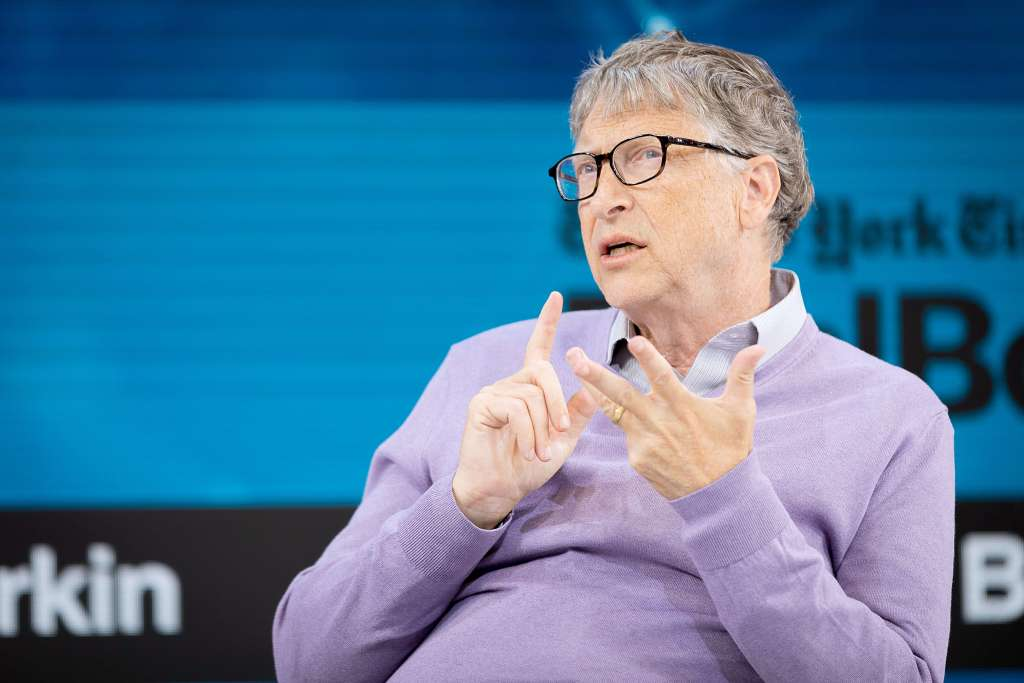

In [38]:
tutorial_image2 = cv2.imread('bill.jpg')
cv2_imshow(tutorial_image2)

In [18]:
!wget https://www.dropbox.com/s/n3xts37k5sqfgok/street.jpg

--2020-05-28 13:32:39--  https://www.dropbox.com/s/n3xts37k5sqfgok/street.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n3xts37k5sqfgok/street.jpg [following]
--2020-05-28 13:32:39--  https://www.dropbox.com/s/raw/n3xts37k5sqfgok/street.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc26039dd71189b0c85931a45675.dl.dropboxusercontent.com/cd/0/inline/A4m7uQ3iKdxfK_0hI66t6_pKX0J9axaLanrEKLxH1zNgWWfX_tNXXiE5jjtfgc8w5qbDnf5PmrLqql9BWehqCvYL1WDDOZCidA7gT-Ap5YfVAG7Go89LUw7monJjBbgQTqw/file# [following]
--2020-05-28 13:32:40--  https://uc26039dd71189b0c85931a45675.dl.dropboxusercontent.com/cd/0/inline/A4m7uQ3iKdxfK_0hI66t6_pKX0J9axaLanrEKLxH1zNgWWfX_tNXXiE5jjtfgc8w5qbDnf5PmrLqql9BWehqCvYL1WDDOZCidA7gT-Ap5YfVAG7Go89LUw7m

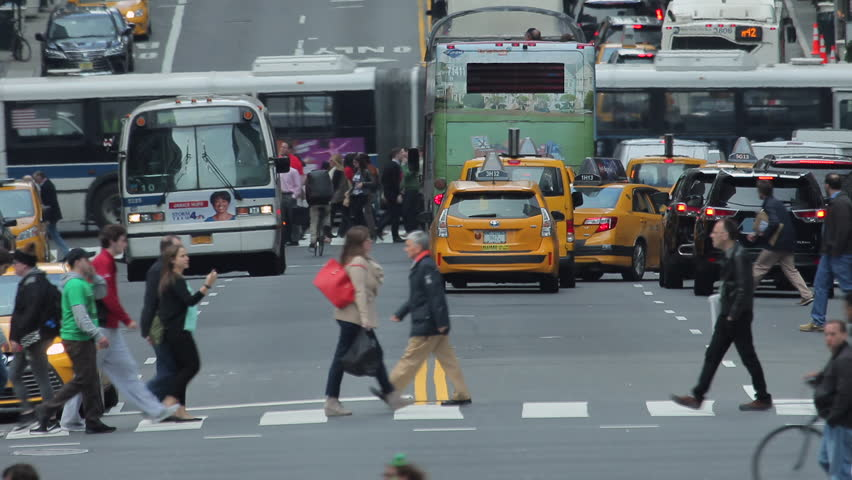

In [40]:
tutorial_image3 = cv2.imread('street.jpg')
cv2_imshow(tutorial_image3)

# Prediction and Visualization

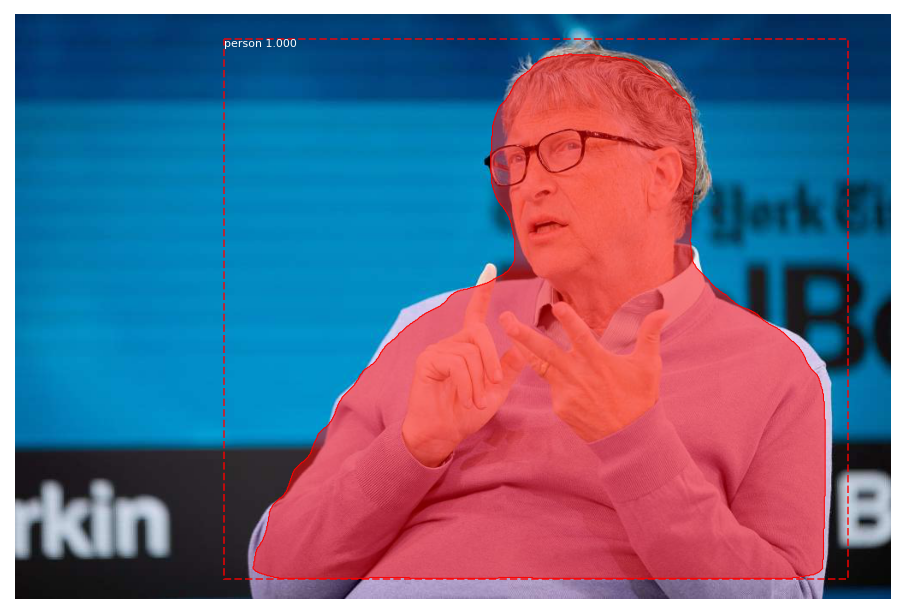

In [41]:
path = '/mydrive/mask_rcnn/bill.jpg'
#'/mydrive/mask_rcnn/street_tutorial.jpeg'
#../images/8829708882_48f263491e_z.jpg'
image = skimage.io.imread(path)

# Run detection
results = model.detect([image], verbose=0)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# PART 2: **Background Removal application** 

In [0]:
path = '/mydrive/mask_rcnn/bill.jpg'
#'/mydrive/mask_rcnn/street_tutorial.jpeg'
#../images/8829708882_48f263491e_z.jpg'
image = skimage.io.imread(path)

# Run detection
results = model.detect([image], verbose=0)

# Visualize results
r = results[0]
#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [0]:
def segment(image, r):
  idx = r['scores'].argmax()
  mask = r['masks'][:,:,idx]
  mask = np.stack((mask,)*3, axis=-1)
  mask = mask.astype('uint8')
  bg = 255 - mask * 255
  mask_img = image*mask
  result = mask_img+ bg
  return result

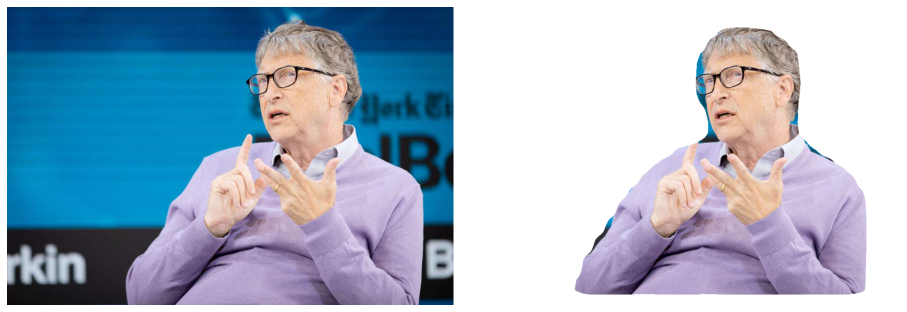

In [81]:
segmentation = segment(image, r)
plt.subplots(1, figsize=(16, 16))
plt.axis('off')
plt.imshow(np.concatenate([image, segmentation], axis = 1))

### BACKGROUND REMOVAL FOR VIDEOS

In [0]:
# Input arguments

#CHANGE CODE HERE
####################################
video = '/mydrive/mask_rcnn/soccer_fight360p.mp4'     ######## put the name of your video file HERE
save_fps = 30
####################################

weightsfile = "/mydrive/mask_rcnn/Mask_RCNN/mask_rcnn_coco.h5" # pre-trained weights 

# Video save codec 
##change this for different video types if you get errors
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#Other options
#cv2.VideoWriter_fourcc('M','P','E','G')
#cv2.VideoWriter_fourcc('M', 'J', 'P', 'G') 
#cv2.VideoWriter_fourcc(*'DIVX') -> para .avi

In [83]:
import time

start = time.time()
videofile = video

cap = cv2.VideoCapture(videofile)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("Video resolution : ", height, width)

assert cap.isOpened(), 'Cannot capture source'


#Add extension mask_rcnn to video name
video_mask_rcnn =  video.split(".")[0] + "_mask_rcnn_foreground." + video.split(".")[1]

#Video save
videoSaved = cv2.VideoWriter(video_mask_rcnn, apiPreference=cv2.CAP_FFMPEG,
                             fourcc = fourcc,fps =save_fps, frameSize=(width, height),	
                             isColor= True)
frames = 0
    
while cap.isOpened():
    
    ret, frame = cap.read()
    if ret:    
        #Inference
        results = model.detect([frame], verbose=0)
        r = results[0]
        #
        #ADDED LINE TO DO FOREGROUND EXTRACTION
        frame = segment(frame,r)
        #
        # video save line
        videoSaved.write(frame)
          
        frames += 1
        if frames%50 == 0: print("{} processed frames".format(frames))       
    else:
        break
videoSaved.release()
end = time.time()
print("Video processed with Masked-RCNN and saved as " + video_mask_rcnn)
print('Total time elapsed: {:.3f} segundos'.format((end - start)))

Video resolution :  360 640
50 processed frames
100 processed frames
150 processed frames
200 processed frames
250 processed frames
300 processed frames
350 processed frames
400 processed frames
450 processed frames
500 processed frames
Video processed with Masked-RCNN and saved as /mydrive/mask_rcnn/soccer_fight360p_mask_rcnn_foreground.mp4
Total time elapsed: 165.759 segundos


Challenge: NOW DO IT FOR BACKGROUND CHANGE!


# PART 3 **Mask-RCNN - on Video**




In [47]:
cd /mydrive/mask_rcnn

/content/gdrive/My Drive/mask_rcnn


In [0]:
!wget  https://www.dropbox.com/s/35jw9yy0hle0wbw/soccer_fight360p.mp4 

--2020-05-21 14:06:04--  https://www.dropbox.com/s/35jw9yy0hle0wbw/soccer_fight360p.mp4
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/35jw9yy0hle0wbw/soccer_fight360p.mp4 [following]
--2020-05-21 14:06:04--  https://www.dropbox.com/s/raw/35jw9yy0hle0wbw/soccer_fight360p.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5d243be63e88c45a9363b8516e.dl.dropboxusercontent.com/cd/0/inline/A4LFHlxMa7pNaAFBIDEG79u1gvmweFGtqZeCrQ0IKKnzYjF-26L4tflUyjTGahvuhrKMABZKmg4eKBquh1_3ZyOAhZzdtHADt-FUdhbgJkislbmJLjLnkxN5WCz-t05xKLk/file# [following]
--2020-05-21 14:06:05--  https://uc5d243be63e88c45a9363b8516e.dl.dropboxusercontent.com/cd/0/inline/A4LFHlxMa7pNaAFBIDEG79u1gvmweFGtqZeCrQ0IKKnzYjF-26L4tflUyjTGahvuhrKMABZKmg4eKBquh1_3ZyO

### Define Parameters

In [0]:
# Input arguments

#CHANGE CODE HERE
####################################
video = '/mydrive/mask_rcnn/soccer_fight360p.mp4'     ######## put the name of your video file HERE
save_fps = 30
####################################


weightsfile = "/mydrive/mask_rcnn/Mask_RCNN/mask_rcnn_coco.h5" # pre-trained weights 


# Video save codec 
##change this for different video types if you get errors
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#Other options
# cv2.VideoWriter_fourcc(*'MP4V')
#cv2.VideoWriter_fourcc('M','P','E','G')
#cv2.VideoWriter_fourcc('M', 'J', 'P', 'G') 
#cv2.VideoWriter_fourcc(*'DIVX') -> para .avi
# cv2.VideoWriter_fourcc(*'MP4V')   

#### See your input video

In [0]:
from IPython.display import HTML
from base64 import b64encode

video_path = video ######## put the name of your video file HERE

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Run Mask-RCNN on video

In [60]:
cd /mydrive/mask_rcnn/Mask_RCNN/mrcnn

/content/gdrive/My Drive/mask_rcnn/Mask_RCNN/mrcnn


In [61]:
ls

config.py    parallel_model.py  utils.py          visualize.py
__init__.py  process_video.py   visualize_cv2.py
model.py     __pycache__/       visualize_cv.py


In [62]:
from google.colab.patches import cv2_imshow
from visualize_cv import display_instances # from visualize_cv2 import display_instances
import time

start = time.time()
videofile = video

cap = cv2.VideoCapture(videofile)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("Video resolution : ", height, width)

assert cap.isOpened(), 'Cannot capture source'


#Add extension mask_rcnn to video name
video_mask_rcnn =  video.split(".")[0] + "_mask_rcnn." + video.split(".")[1]

#Video save
videoSaved = cv2.VideoWriter(video_mask_rcnn, apiPreference=cv2.CAP_FFMPEG,
                             fourcc = fourcc,fps =save_fps, frameSize=(width, height),	
                             isColor= True)
frames = 0
    
while cap.isOpened():
    
    ret, frame = cap.read()
    if ret:    
        #Inference
        results = model.detect([frame], verbose=0)
        r = results[0]
        frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
        # video save line
        videoSaved.write(frame)
          
        frames += 1
        if frames%50 == 0: print("{} processed frames".format(frames))       
    else:
        break
videoSaved.release()
end = time.time()
print("Video processed with Masked-RCNN and saved as " + video_mask_rcnn)
print('Total time elapsed: {:.3f} segundos'.format((end - start)))

Video resolution :  360 640
50 processed frames
100 processed frames
150 processed frames
200 processed frames
250 processed frames
300 processed frames
350 processed frames
400 processed frames
450 processed frames
500 processed frames
Video processed with Masked-RCNN and saved as /mydrive/mask_rcnn/soccer_fight360p_mask_rcnn.mp4
Total time elapsed: 209.065 segundos


NOW CHECK THE PROCESSED VIDEO ON YOUR Google Drive mrcnn folder

# PART 4 **Mask-RCNN - on Video application**

### [Mask-RCNN-Shiny Project](https://github.com/huuuuusy/Mask-RCNN-Shiny) 


In [68]:
cd /mydrive/mask_rcnn

/content/gdrive/My Drive/mask_rcnn


In [0]:
# Input arguments

#CHANGE CODE HERE
####################################
video = '/mydrive/mask_rcnn/soccer_fight360p.mp4'     ######## put the name of your video file HERE
save_fps = 30
####################################

weightsfile = "/mydrive/mask_rcnn/mask_rcnn_coco.h5" # pre-trained weights 

# Video save codec 
##change this for different video types if you get errors
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#Other options
# cv2.VideoWriter_fourcc(*'MP4V')
#cv2.VideoWriter_fourcc('M','P','E','G')
#cv2.VideoWriter_fourcc('M', 'J', 'P', 'G') 
#cv2.VideoWriter_fourcc(*'DIVX') -> para .avi
# cv2.VideoWriter_fourcc(*'MP4V')   


apply_mask is used to change the background information to grayscale.



In [0]:
# This function is used to change the colorful background information to grayscale.
# image[:,:,0] is the Blue channel,image[:,:,1] is the Green channel, image[:,:,2] is the Red channel
# mask == 0 means that this pixel is not belong to the object.
# np.where function means that if the pixel belong to background, change it to gray_image.
# Since the gray_image is 2D, for each pixel in background, we should set 3 channels to the same value to keep the grayscale.

def apply_mask(image, mask):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image[:, :, 0] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 2]
    )
    return image

display_instances is used to show the object detection result in original image.

In [0]:
# This function is used to show the object detection result in original image.
def display_instances(image, boxes, masks, ids, names, scores):
    # max_area will save the largest object for all the detection results
    max_area = 0
    
    # n_instances saves the amount of all objects
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue

        # compute the square of each object
        y1, x1, y2, x2 = boxes[i]
        square = (y2 - y1) * (x2 - x1)

        # use label to select person object from all the 80 classes in COCO dataset
        label = names[ids[i]]
        if label == 'person':
            # save the largest object in the image as main character
            # other people will be regarded as background
            if square > max_area:
                max_area = square
                mask = masks[:, :, i]
            else:
                continue
        else:
            continue

        # apply mask for the image
        image = apply_mask(image, mask)
        
    return image

In [0]:
from google.colab.patches import cv2_imshow
#from visualize_cv import display_instances
import time

start = time.time()
videofile = video

cap = cv2.VideoCapture(videofile)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

print("Video resolution : ", height, width)
assert cap.isOpened(), 'Cannot capture source'



#Add extension mask_rcnn to video name
video_mask_rcnn =  video.split(".")[0] + "_mask_rcnn_new_background." + video.split(".")[1]

#Video save
videoSaved = cv2.VideoWriter(video_mask_rcnn, apiPreference=cv2.CAP_FFMPEG,
                             fourcc = fourcc,fps =save_fps, frameSize=(width, height),	
                             isColor= True)

frames = 0
    
while cap.isOpened():
    
    ret, frame = cap.read()
    if ret:
        
        #Inference
        #
        results = model.detect([frame], verbose=0)
        r = results[0]
        frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
                
        # video save line
        #
        videoSaved.write(frame)
          
        frames += 1
        if frames%50 == 0: print("{} processed frames ok".format(frames))       
    else:
        break
videoSaved.release()
end = time.time()
print("Video processed with Masked-RCNN and saved as " + video_mask_rcnn)
print('Total time elapsed: {:.3f} segundos'.format((end - start)))

Video resolution :  360 640
50 processed frames ok
100 processed frames ok
150 processed frames ok
200 processed frames ok
250 processed frames ok
300 processed frames ok
350 processed frames ok
400 processed frames ok
450 processed frames ok
500 processed frames ok
Video processed with Masked-RCNN and saved as /mydrive/mask_rcnn/soccer_fight360p_mask_rcnn_new_background.mp4
Total time elapsed: 406.145 segundos


# PART 5: **How to train a Mask-RCNN model on custom dataset**


Follow one of the following:

> [OFFICIAL instrunctions in Matterport's repo](https://github.com/matterport/Mask_RCNN#training-on-your-own-dataset) and its [blog](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46)



> [Machine Learning Mastery tutorial](https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/) 


> [Short tutorial](https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d) from Renu Khandelwal







# Exercise
---
1) **Test the Mask-RCNN on your image**


2)  **Test the Mask-RCNN on your own video**


Examples of possible videos you can use 


1. Indian War (30s) - 1080p : [original link](https://www.youtube.com/watch?v=DcV7d3py-Mw) /[download link](https://www.dropbox.com/s/mmncfyccvgevm87/IndianWar1080p.mp4)
					       				
                        
2. Soccer tactics (2min) 360p 	: [original link](https://www.youtube.com/watch?v=c83yE-s_Wf0) /[download link](https://www.dropbox.com/s/lf99d8lzwqlj2zs/soccer_tactics360p.mp4)

3. Girl soccer fight (17s) - 720p : [original link](https://www.youtube.com/watch?v=oWJLump8Jjk/)/ [download link](https://www.dropbox.com/s/0o1bourc6oyil5a/soccer_fight720p.mp4)
                

4. Girl soccer fight (17s) - 360p:	 [original link](https://www.youtube.com/watch?v=oWJLump8Jjk/)/ [download link](https://www.dropbox.com/s/35jw9yy0hle0wbw/soccer_fight360p.mp4)			
		
5. Animals chasing people (2min 25s) 360p :  [original link](https://www.youtube.com/watch?v=F1svRmDlsL4)/ [download link]( https://www.dropbox.com/s/951sqbtge8dzcsr/chasing_animals360p.mp4)	     

6. Hungry monkeys (40s) 720p:				 [original link](https://www.youtube.com/watch?v=22JgHBb-0dg)/ [download link](https://www.dropbox.com/s/isxbju7yabzlnin/hungry_monkeys720p.mp4)  
									
7. Super animals (30s) 720p:		 [original link]( https://www.youtube.com/watch?v=PaMPdz-3Agg)/ [download link](https://www.dropbox.com/s/cuku94guronf5tf/super_animals720p.mp4) 	

OBS: Right click and choose "stats for nerds"  to see frame rate of video you want to download (normally its 25~30)

# References
---

This Mask-RCNN colab notebook was based on: 

> Matterport [demo notebook](https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb) from [/matterport/Mask_RCNN repo](https://github.com/matterport/Mask_RCNN)







> Mark Jay's 3-part [video series](https://www.youtube.com/watch?v=2TikTv6PWDw&list=PLX-LrBk6h3wRAF22jBUxDgOvyhIgLN4Cg) and [markjay4k/Mask-RCNN-series repo](https://github.com/markjay4k/Mask-RCNN-series)




> [Mask-RCNN-Shiny Project](https://github.com/huuuuusy/Mask-RCNN-Shiny)




Recommended reading

> [Article](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46) on Matterport's blog with implementation details


> Computer Vision — A journey from CNN to Mask R-CNN and YOLO - [Part 1](https://towardsdatascience.com/computer-vision-a-journey-from-cnn-to-mask-r-cnn-and-yolo-1d141eba6e04) and [Part 4](https://towardsdatascience.com/computer-vision-instance-segmentation-with-mask-r-cnn-7983502fcad1)



